In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix

## Loading data

In [11]:
data = pd.read_csv("../dataset/dataset_4.csv", sep = ";").drop("Unnamed: 0", 1)
data.describe()

,TP_ESCOLA,TP_LINGUA,Escolaridade_Pai,Escolaridade_Mae,Ocupacao_Pai,Ocupacao_Mae,Renda_Mensal,Computador,DESEMPENHO_BAIXO,Renda_per_capta,Pessoas_por_computador,Pessoas_por_celular
count,3.168898e+06,3.168898e+06,3.168898e+06,3.168898e+06,3.168898e+06,3.168898e+06,3.168898e+06,3.168898e+06,3.168898e+06,3.168898e+06,3.168898e+06,3.168898e+06
mean,4.491498e-01,5.271628e-01,3.439471e+00,4.073692e+00,2.296138e+00,2.226948e+00,3.496580e+00,6.882020e-01,5.000047e-01,8.346541e+02,1.819410e+00,1.873938e+00
std,6.148688e-01,4.992617e-01,1.873869e+00,1.719509e+00,1.392760e+00,1.279828e+00,3.254036e+00,7.721223e-01,5.000001e-01,1.252211e+03,1.986800e+00,1.311751e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.994000e+02,0.000000e+00,1.000000e+00
50%,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,4.990000e+02,1.333333e+00,1.500000e+00
75%,1.000000e+00,1.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,3.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,8.316667e+02,3.000000e+00,2.000000e+00
max,2.000000e+00,1.000000e+00,7.000000e+00,7.000000e+00,5.000000e+00,5.000000e+00,1.600000e+01,4.000000e+00,1.000000e+00,3.000000e+04,2.000000e+01,2.000000e+01


### Standarizing values

In [3]:
data_std = data
for col in data_std.columns:
    mean = data_std[col].mean()
    std = data_std[col].std()
    data_std[col] = (data_std[col]-mean)/std

## Clusters

### Using the Elbow Method to find the best number of clusters

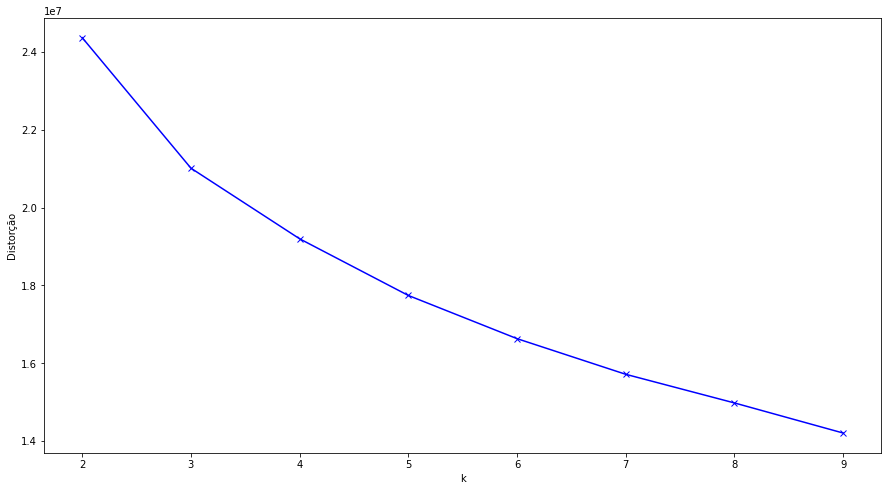

In [4]:
distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_std.drop(["DESEMPENHO_BAIXO"], 1))
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(15,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distorção')
plt.show()

In [4]:
# Applying K-Means
n = 3
kmeans = KMeans(n_clusters = n).fit(data_std.drop(["DESEMPENHO_BAIXO"], 1))
labels = kmeans.labels_

In [5]:
# Applying PCA to reduce dimentions for plotting purposes
    
pca = PCA(n_components = 2).fit(np.array(data_std.drop(["DESEMPENHO_BAIXO"], 1)))
pca_2d = pca.transform(np.array(data_std.drop(["DESEMPENHO_BAIXO"], 1)))
centers = pca.transform(kmeans.cluster_centers_)
print("Explained variance: " + str(round(100*sum(pca.explained_variance_ratio_), 2)) + "%")

Explained variance: 47.05%


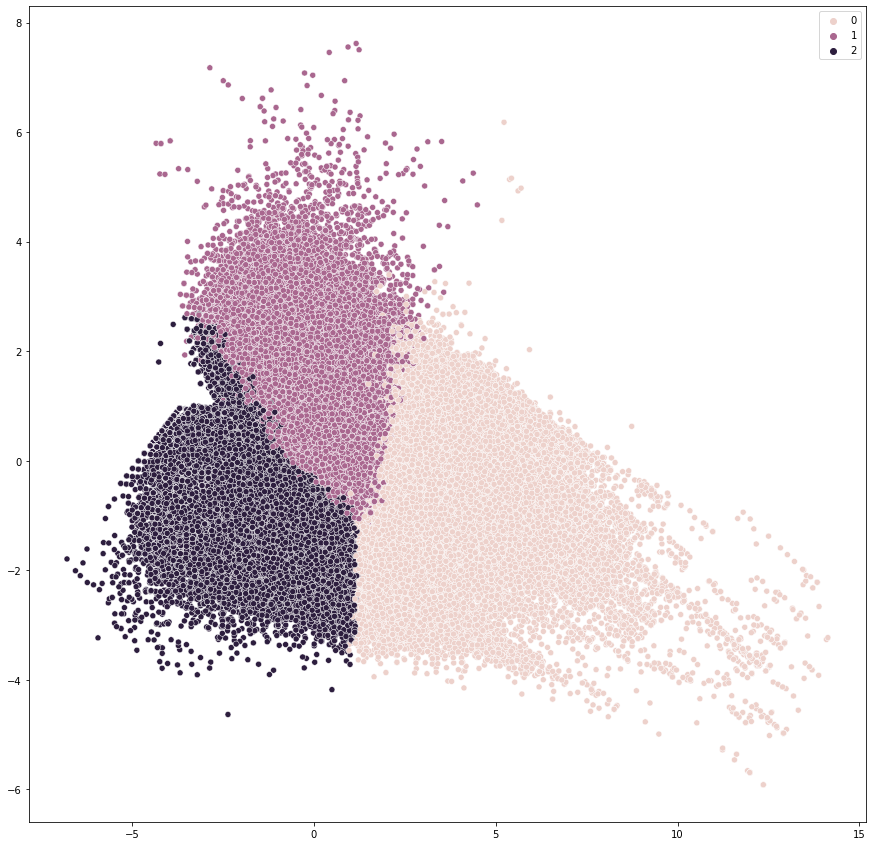

In [6]:
plt.figure(figsize=(15, 15))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=labels, cmap = "mako")

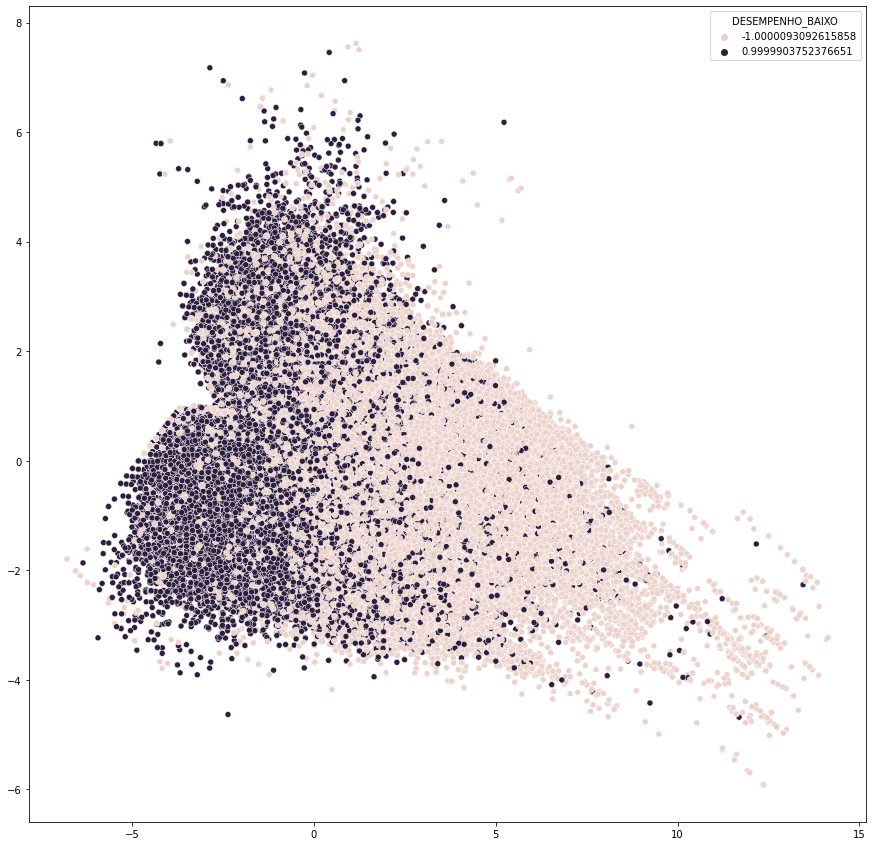

In [7]:
plt.figure(figsize=(15, 15))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=data["DESEMPENHO_BAIXO"])

### Removing the intermediate cluster

In [12]:
data["Cluster"] = labels
data = data[data["Cluster"]!=1]
data = data.drop("Cluster", 1)
train, test = train_test_split(data, test_size=0.30)

In [13]:
weight = len(train[train["DESEMPENHO_BAIXO"] == 1])/len(train[train["DESEMPENHO_BAIXO"] == 0])

Precision: 0.7404339318205225
Recall: 0.8931347898038512


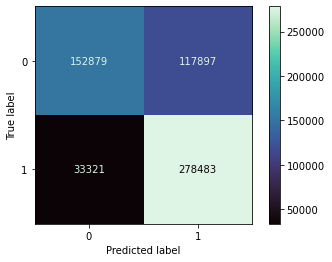

In [14]:
model = xgb.XGBClassifier(n_jobs = -1, scale_pos_weight = weight).fit(train.drop(["DESEMPENHO_BAIXO"], 1), train["DESEMPENHO_BAIXO"])
predictions = model.predict(test.drop(["DESEMPENHO_BAIXO"], 1))
precision = precision_score(test["DESEMPENHO_BAIXO"] , predictions, average = "micro")
recall = recall_score(test["DESEMPENHO_BAIXO"] , predictions, average = "binary")
print("Precision: " + str(precision))
print("Recall: " + str(recall))
plot_confusion_matrix(model, test.drop(["DESEMPENHO_BAIXO"], 1), test["DESEMPENHO_BAIXO"], cmap = "mako")